In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from copy import deepcopy
import re
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



### Reading data into Pandas
I decided to read the most frequent csv dataset for this project. The data is from teh 2014-2015 school year

In [2]:
df = pd.read_csv("MERGED2011_12_PP.csv")

### Preprocessing round 1
- remove features with only null values
- remove features with only 1 value across all obs
- turn certain features values into the string values that they represent (ie. `HIGHDEG`) is suppose to represent the highest degree awarded

In [3]:
def drop_svf(df):
    '''
    drop single value features (where all observations in that column have only 1 value)
    df : dataframe 
    return : dataframe
    '''
    df_cleaned = deepcopy(df)
    for column in df.columns:
        if len(df[column].value_counts()) == 1:
            df_cleaned = df_cleaned.drop(column, axis = 1)
    return df_cleaned

def replace_category(df, col_name, name_key):
    '''
    replace the integer/float representation of values in a column 
    by the corresponding string values of name_key
    
    df : dataframe to operate on
    col_name : a list of column names of which the replacement will take place
    name_key : the corresponding replacement list of strings to which each of the values 
               in col_name will be replaced by
               
    return : the newly modified dataframe
    '''
    new_df = df.copy()
    for col in col_name:
#         assert str(df[col].dtype) == 'float64' or str(df[col].dtype) == 'int64'
        new_col = []
        for i,obs in enumerate(df[col]):
            if np.isnan(obs):
                str_val = np.nan
            else:
                str_val = name_key[int(obs)]
            new_col.append(str_val)
        new_df[col] = new_col
    return new_df

In [4]:
df = df.dropna(axis = 1, how='all')
df = drop_svf(df)
df.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,SCH_DEG,MAIN,NUMBRANCH,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,3.0,1,1,...,NaN,0.000000,1088.0,NaN,NaN,1,0.4786,0.5214,1514.0,1438.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,3.0,1,1,...,NaN,0.283168,1515.0,NaN,NaN,1,0.4154,0.5846,2836.0,3160.0
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,3.0,1,1,...,NaN,0.000000,4.0,NaN,NaN,1,0.4389,0.5611,315.0,266.0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,3.0,1,1,...,NaN,0.348243,626.0,NaN,NaN,1,0.5402,0.4598,1083.0,1208.0
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,3.0,1,1,...,NaN,0.000000,1198.0,NaN,NaN,1,0.4054,0.5946,2045.0,1957.0


In [5]:
# save the id and name of institution because I might need it later
id_name = df[['UNITID', 'INSTNM']]

In [306]:
deg_name = ['not classified','certificate','associate','bachelor','graduate']
control_name = ['','public', 'private_nonprofit', 'private_for-profit']
region_name = ['us_service_schools', 'new_england', 'mid_east', 'great_lakes', 'plains',
               'southeast', 'southwest', 'rocky_mountains', 'far_west', 'outlying_areas']
iclevel_name = ['','4_year','2_year','less_than_2_year']

# df = replace_category(df, ['HIGHDEG','PREDDEG'], deg_name)
# df = replace_category(df, ['CONTROL'], control_name)
# df = replace_category(df, ['REGION'], region_name)
# df = replace_category(df, ['ICLEVEL'], iclevel_name)



### College University subset (Preprocessing round 2)

- I am going to begin my analysis first with schools that have undergraduate students enrolled
- I am going to drop certian redundant and unnecessary features (mostly names, zip codes, ids)
- I am going to drop observation with more than 40% null values to insure quaity of our observations when we impute missing features later


In [307]:
def remove_row_missing(df, threshold):
    '''
    remove observations in df that has more than threshold% of null values
    
    df : a dataframe
    threshold : the cuttoff ratio of unavailable data that will dictate the dropping of an observation
    
    return : a new dataframe with observations dropped
    '''
    new_df = df.copy()
    length = len(df.columns)
    
    for i, row in df.iterrows():
        num_nans = row.isnull().sum()
        
        ratio = num_nans / length
        
        if ratio > threshold:
            new_df.drop(i, inplace = True)
            
    return new_df.reset_index(drop=True)


In [308]:
df_college = df[df.UGDS > 0].reset_index(drop='True')
df_college = df_college.drop(['OPEID','INSTNM','CITY','ZIP','OPEID6','ST_FIPS',
                              'SCH_DEG','STABBR','REPAY_DT_MDN','ALIAS'], axis = 1)
df_college = remove_row_missing(df_college, 0.8)
df_college.head()

,UNITID,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,REGION,ADM_RATE,ADM_RATE_ALL,SATVR25,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,1,1,bachelor,graduate,public,southeast,0.5010,0.5010,370.0,...,NaN,0.000000,1088.0,NaN,NaN,4_year,0.4786,0.5214,1514.0,1438.0
1,100663,1,1,bachelor,graduate,public,southeast,0.7223,0.7223,500.0,...,NaN,0.283168,1515.0,NaN,NaN,4_year,0.4154,0.5846,2836.0,3160.0
2,100690,1,1,bachelor,graduate,private_nonprofit,southeast,NaN,NaN,NaN,...,NaN,0.000000,4.0,NaN,NaN,4_year,0.4389,0.5611,315.0,266.0
3,100706,1,1,bachelor,graduate,public,southeast,0.6368,0.6368,500.0,...,NaN,0.348243,626.0,NaN,NaN,4_year,0.5402,0.4598,1083.0,1208.0
4,100724,1,1,bachelor,graduate,public,southeast,0.5080,0.5080,360.0,...,NaN,0.000000,1198.0,NaN,NaN,4_year,0.4054,0.5946,2045.0,1957.0


In [309]:
df_college.shape

(7042, 1575)

### Deciding on which features to predict
I am going to predict mean income after graduation from these schools. Since I am interested in the longer term mean earnings for graduates, I will be trying to predict `MN_EARN_WNE_P10`. Moreoever, there will generally more variabilty for earnings data the more years after graduation, possibly giving us more interesting results.

- I will then remove all features that are other ways to represent earning information (ie. `MN_EARN_WNE_P6`)  because they are basically the same measure as my target variable.
- I will also remove all information regarding repayment since that is also highly related to our target variable, diminishing the task of this project, which is to use static school information to predict post graduation earnings

In [310]:
# list of column names on earnings that will be removed due to relationship with MN_EARN_WNE_P10
loe = list(df_college.columns[df_college.columns.to_series().str.contains('_EARN_')][1:])
loe.extend(list(df_college.columns[df_college.columns.to_series().str.contains('GT_')]))

# list of column names on repayment that will be removed due too strong og a relationship with MN_EARN_WNE_P10
lor = list(df_college.columns[df_college.columns.to_series().str.contains('RPY')])

# list of column names on repayment that will be removed due too strong og a relationship with MN_EARN_WNE_P10
lod = list(df_college.columns[df_college.columns.to_series().str.contains('DEBT')])

df_college = df_college.drop(loe, axis = 1)
df_college = df_college.drop(lor, axis = 1)
df_college = df_college.drop(lod, axis = 1)
df_college.head()

,UNITID,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,REGION,ADM_RATE,ADM_RATE_ALL,SATVR25,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,1,1,bachelor,graduate,public,southeast,0.5010,0.5010,370.0,...,NaN,0.000000,1088.0,NaN,NaN,4_year,0.4786,0.5214,1514.0,1438.0
1,100663,1,1,bachelor,graduate,public,southeast,0.7223,0.7223,500.0,...,NaN,0.283168,1515.0,NaN,NaN,4_year,0.4154,0.5846,2836.0,3160.0
2,100690,1,1,bachelor,graduate,private_nonprofit,southeast,NaN,NaN,NaN,...,NaN,0.000000,4.0,NaN,NaN,4_year,0.4389,0.5611,315.0,266.0
3,100706,1,1,bachelor,graduate,public,southeast,0.6368,0.6368,500.0,...,NaN,0.348243,626.0,NaN,NaN,4_year,0.5402,0.4598,1083.0,1208.0
4,100724,1,1,bachelor,graduate,public,southeast,0.5080,0.5080,360.0,...,NaN,0.000000,1198.0,NaN,NaN,4_year,0.4054,0.5946,2045.0,1957.0


### Removing features with too many nulls and privacy supressed columns and replace null values in each column by 0 (Preprocessing round 3)

- I am also going to drop features that have more than 20% missing data as imputation later will be troublesome with so much missing values.
- I am going to replace values in ordinal features will with 0 and create another binary value feature right after it indicating whether whether the corresponding value in the previous feature has nan.

For categorical variables I can do the same because having null value for that observation inidicates the absence of its categorical quality, which is itself a category, a quality.

In [311]:
def remove_col_missing(df, threshold):
    '''
    remove features in df that has more than threshold% of null values + privacy suppressed values
    
    df : a dataframe
    threshold : the cuttoff ratio of unavailable data that will dictate the dropping of an features
    
    return : a new dataframe with features dropped
    '''
    new_df = df.copy()
    length = len(df)
    
    for col in list(df.columns):
        num_nans = df[col].isnull().sum()
        ps = list(df[col]).count('PrivacySuppressed')
        
        ratio = (num_nans + ps) / length
        
        if ratio > threshold and col != 'MN_EARN_WNE_P10':
            new_df.drop(col, axis = 1, inplace = True)
            
    return new_df.reset_index(drop=True)


# let us create the binary features first
def create_null_indicator(df):
    '''
    for every column in the dataframe with null values in it, create another 0/1 binary column 
    right after it indicating whether the corresponinf row obs in the previous column is null
    
    df : a dataframe
    return : a dataframe with additional columns created
    '''
    new_df = df.copy()
    
    for i in range(len(df.columns)):
        
        if not df[df.columns[i]].isnull().values.any():
            continue
            
        null_indicator = []
        
        for obs in df[df.columns[i]]:
            # np.nan == np.nan will yield false
            if obs == obs:
                null_indicator.append(0)
            else:
                null_indicator.append(1)
                
        col_name = str(df.columns[i]) + '_ISNULL'
        index = list(new_df.columns).index(df.columns[i])
        
        new_df.insert(index + 1, column = col_name, value = np.array(null_indicator))
    return new_df

In [312]:
df_college = remove_col_missing(df_college, 0.6)
df_college = create_null_indicator(df_college)
df_college.fillna(0, inplace=True)


### Writing out file for imputation

In [317]:
df_college.to_csv('df_college3.csv',index=False,)

### Privacy suppressed columns

After dealing with the null values, we still have privacy suppressed values in the dataset to handle. However, for these values, we can be sure that they exist but has been suppressed due to privacy issues usally for small schools with less people. Therefore, imputing them would be more acceptable than imputing missing values where we are not even able to determine whether its missing or do not apply

I applied Multiple Imputation Chained Equation on the dataset for privacy suppressed value. SInce python does not have a good enough imputation package that support this method, I did the imputation in R. Now I am reading back the 5 completed imputed dataset into pandas

In [260]:
chunks = pd.read_csv('imputed3.csv',chunksize=7042,)

In [261]:
completed_dfs = []
for chunk in chunks:
    completed_dfs.append(pd.DataFrame(chunk).reset_index(drop=True))
completed_dfs = completed_dfs[1:]

### Remove some collinear features

When I was runnign the imputation in R, part of what the algorithm did was to drop features in teh imputation process that it deemed strongly collinear to one of the other features. Therefore, certain features still have NAs in them. We will take adavantage of this singal indicating that the correspoding feature is collinear to some other feature and can therefore be dropped without sacrificing our modeling power later on.

In [262]:
def remove_collinear_col(dfs):
    '''
    remove columns in all dataframe that has null values in them
    
    dfs : list of dataframes
    return : list of dataframes with null columns removed
    '''
    new_imputed_dfs = []
    for df in dfs:
        new_df = df.copy()
        for col in df.columns:
            if df[col].isnull().values.any():
                new_df.drop(col, axis = 1, inplace = True)
                try:
                    new_df.drop(col + '_ISNULL', axis = 1, inplace = True)
                except ValueError: # the column had no null values, which is fine
                    pass
        new_imputed_dfs.append(new_df)
                
    return new_imputed_dfs

def remove_missing_target(dfs):
    new_dfs = []
    for df in dfs:
        new_df = df.copy()
        new_df = new_df.drop('MN_EARN_WNE_P10_ISNULL', axis = 1,)
        new_df = df[df['MN_EARN_WNE_P10'] != 0]
        new_dfs.append(new_df)
    return new_dfs

In [263]:

dfs = remove_collinear_col(completed_dfs)

remove the 'ISNNULL' column for the target variable along with observations that has null in target variable

In [264]:
dfs = remove_missing_target(dfs)


### Turn each categorical feature into its own column of 0/1 binary indicator
features such as `PREDDEG1`, `HIGHDEG`, `CONTROL` etc. are categorical variable, so we are goign to use patsy to turn them into multiple binary columns

In [265]:
import patsy
from  pandas.api.types import is_categorical_dtype

In [266]:
def binarify(df, col_name,):
    '''
    transform the categorical column specified by col_name in df into a binary column for each of the categories
    
    df : dataframe
    col_name : list of categorical colum names in df that are to be transformed
    '''
    new_df = df.copy()
    
    for name in col_name:
        col_position = list(new_df.columns).index(name)
        
        binarified = pd.get_dummies(df[name], prefix=name)
        
        for i,category in enumerate(binarified):
            new_df.insert(col_position + i + 1, category, binarified[category])
            
        new_df = new_df.drop([name], axis = 1,)
            
    return new_df

In [267]:
categorical = ['PREDDEG','HIGHDEG','CONTROL','REGION','ICLEVEL']
dfs = [binarify(df,categorical) for df in dfs]

### Averaging the imputations

Because I have 5 complete dataset after the imputation, I am going to average all the values across different dataframes together to get 1 complete dataframe.

I am aware that this approach may slghtly diminish the uncertainty nature of the impuation because nwo I have a point estimate of the privacy suppressed value rather than a handful of them. However, Let us first see how this goes.

In [268]:
from collections import defaultdict

In [269]:
def average_dataframes(dfs):
    '''
    average each cell across multiple dataframes 
    
    dfs : list of dataframe
    return : a dataframe with each cell corrected to the average across all dataframes in dfs (dataframe)
    '''
    col_names = dfs[0].columns[3:]
    num_obs = len(dfs[0])
    lst = []
    for col in col_names:
        if col == 'UNITID':
            lst.append(dfs[1][col])
            continue
        col_sum = np.array([0]*num_obs)
        
        for df in dfs:
            col_sum = col_sum + np.array(df[col])
    
        lst.append(col_sum / np.array([len(dfs)]*num_obs))
        
    
    return pd.DataFrame(np.array(lst).T, columns=col_names)
        

In [270]:
df_college = average_dataframes(dfs)

In [271]:
intercept = np.array([1]*len(dfs[0]))
df_college.insert(0, 'INTERCEPT',value = intercept)

### Feature Engineering
I did not immediately jump into feature engineering intially. I added the section here because it is most appropriate to derive new features and append it to the dataaframe prior to standardization and modeling. This part was added after all the modeling has been completed

**Note** : please comment this part out if you wish to see the pre-engineered result

In [272]:
def create_race_diversity_feat(df, col_names):
    '''
    create a racial diversity index
    calculcation based on 1 - sum((x_i)**2) where x_i stands for the percentage 
    of population that identifies as that specfic race (i)
    
    df : (dataframe) the predictor dataframe containing race features
    col_names : (list) a list of strings where the string refers to the race feature names
    return : (list) a list of racial diversity index score of all the observation in the dataframe
    '''

    diversity = []
    for i, row in df_college.iterrows():
        diverse_sum = 0
        for col in col_names:
            diverse_sum += row[col]**2

        diversity.append(1-diverse_sum)
        
    return diversity
    

In [273]:
eths = ['UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN', 'UGDS_NHPI', 'UGDS_2MOR']
df_college['DIVERSE'] = create_race_diversity_feat(df_college,eths)
df_college = df_college.drop(eths, axis = 1)

### Standardizing our predictors
This will be quite important if we decide to run a regression. Furthermore, I am goign to log transform the target variable as current literature have consistently shown that Earning data are usually log normal

In [274]:
def standardize(df, lob):
    '''
    standardize columns that are not binary indicators in the dataframe
    
    df : dataframe
    lob : list of partial matching strings for the features that will not be standardized
    return : a standardized df
    '''
    new_df = df.copy()
    for col in list(df.columns):
        if True in [s in col for s in lob]:
            continue
        else:
            mean = df[col].mean()
            std = df[col].std()
            new_df[col] = (df[col] - mean)/std
    return new_df

In [275]:
# a non standarized copy just in case
df_college_un = df_college.copy()

In [276]:
df_college = standardize(df_college,['UNITID','PREDDEG','HIGHDEG','CONTOL','REGION','ICLEVEL','ISNULL','EARN','INTERCEPT'])

# Emprically, earnings are typically lognormal
df_college['log_MN_EARN_WNE_P10'] = np.log(df_college.MN_EARN_WNE_P10)

##### Lets take a quick look at the distribution of our target variable after transformation

This is a crucial step because we will begin by modeling using a linear regression model. Often times a log transformation of our y variabl will increase he overal predictive power of our model

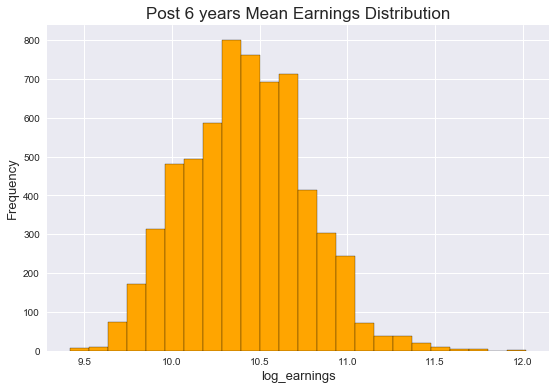

In [277]:
fig, target_hist = plt.subplots(figsize = (9,6))
plt.hist(df_college.log_MN_EARN_WNE_P10,bins = 24, color='orange', edgecolor='black')
plt.title('Post 6 years Mean Earnings Distribution', size = 17)
plt.xlabel('log_earnings', size = 13)
plt.ylabel('Frequency', size = 13)

# roughly normal

### Train test split
I am going to split my dataset into train, test, and validation set first. 

In [278]:
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

#### standardized version

In [279]:
y = df_college.log_MN_EARN_WNE_P10
X = df_college.drop(['log_MN_EARN_WNE_P10','MN_EARN_WNE_P10','UNITID'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 5555)

#### unstandardized version

In [280]:
df_college_un['log_MN_EARN_WNE_P10'] = np.log(df_college_un.MN_EARN_WNE_P10)
y_un = df_college_un.log_MN_EARN_WNE_P10
X_un = df_college_un.drop(['log_MN_EARN_WNE_P10','MN_EARN_WNE_P10','UNITID'], axis = 1)

X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(X_un, y_un, test_size = 0.25, random_state = 5555)

## Modeling
Having removed certain collinear variables from the imputation process in R, we still have a relatively large feature space of 435 variables.

We could do a number of things, run a ridge regression to deal with potentially persisting multicollinearity problem that still exists in our dataset   
Please refer :  
http://web.as.uky.edu/statistics/users/pbreheny/764-f11/notes/9-1.pdf

We could also run Lasso for its embedded feature selection methods

In [281]:
from sklearn.linear_model import RidgeCV,LassoCV, ElasticNetCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LinearRegression

In [282]:
def find_alpha(X_train, y_train, n_folds, alphas, l1_ratio = 0.5):
    '''
    use cross validation method to determine MSE of differnet penalty (alpha) parameters
    in our l2 regularized model.
    
    X_train : feature matrix (dataframe)
    y_train : target_variable (series, np.array, etc..)
    n_folds : number of folds to divide up for cross valdation (int)
    alphas : list of penalty parameter to test out (list)
    return: MSE of different penalty parameters (list)
    '''
    kf = KFold(n=len(X_train), n_folds=n_folds, shuffle=True, random_state=5555)
    alphas=alphas
    all_mse_scores= np.array(len(alphas)*[0.0])

    for train,test in kf:

        X_cv_train= X_train.iloc[train]
        y_cv_train= y_train.iloc[train]
        X_cv_test= X_train.iloc[test]
        y_cv_test= y_train.iloc[test]

        mse_score=[]
        for a in alphas:
            est=ElasticNet(alpha=a, l1_ratio=l1_ratio, fit_intercept=True,
                           max_iter=1000, tol = 0.08, normalize = True)
            est.fit(X_cv_train,y_cv_train)
            mse = np.mean((np.array((y_cv_test))-est.predict(X_cv_test))**2)
            mse_score.append(mse)
        all_mse_scores += mse_score

    return all_mse_scores/len(alphas)

In [283]:
find_alpha(X_train, y_train, 5, alphas = [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,3,4,5,], l1_ratio= 0.1)



array([ 0.00797865,  0.00797304,  0.0079196 ,  0.00751016,  0.00742817,
        0.01123794,  0.02856969,  0.04512489,  0.04512489,  0.04512489,
        0.04512489,  0.04512489,  0.04512489])

#### Let us define a validation set
 top is standardized, bottom is unstandardized

In [284]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state = 5555)

In [285]:
X_train_un, X_valid_un, y_train_un, y_valid_un = train_test_split(X_train_un, y_train_un, test_size = 0.25, random_state = 5555)

#### Implementing Ridge Regression

In [286]:
# fitting and checking coef with ElasticNet

rcv = RidgeCV(alphas = [3], fit_intercept = True, cv = 10,)
rcv.fit(X_train, y_train)

# scoring our model on our validation set
print('Ridge')
print('R2: ' + str(rcv.score(X_valid,y_valid)))
print('MSE: ' + str(np.mean((rcv.predict(X_valid)-y_valid)**2)))


Ridge
R2: 0.849453360948
MSE: 0.01750512640324569


#### Implementing Lasso Regression

In [287]:
# fitting and checking coef with Lasso

lcv = LassoCV(alphas = [1e-4], tol=0.0001, fit_intercept = False, max_iter=1000,random_state=5555)
lcv.fit(X_train, y_train)

# scoring our model on our validation set
print('Lasso')
print('R2: ' + str(lcv.score(X_valid,y_valid)))
print('MSE: ' + str(np.mean((lcv.predict(X_valid)-y_valid)**2)))


Lasso
R2: 0.848091276111
MSE: 0.017663505676254673


#### Implementing ElasticNet

In [288]:
# fitting and checking coef with ElasticNet

encv = ElasticNetCV(l1_ratio=0.4, alphas = [1e-3], fit_intercept = True, tol = 0.055, max_iter=1200,random_state=5555)
encv.fit(X_train, y_train)

# scoring our model on our validation set
print('ElasticNet')
print('R2: ' + str(encv.score(X_valid,y_valid)))
print('MSE: ' + str(np.mean((encv.predict(X_valid)-y_valid)**2)))


ElasticNet
R2: 0.848011697381
MSE: 0.017672758860067108


### Nonlinearity

The underlying predictors may not be linearly related to our response variable

#### Try KNN regression to caputre nonlinearity in dataset

The nearest negibor approach will be able to capture nonlinear relationship in our dataset because its estimation of an observation will be based on the local values around it.

In [289]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

In [290]:
def plot_knn_k_performance(X_train,y_train):
    '''
    plot a graph that shows the optimal k parameter to set to lower the mean squared error
    X_train : (dataframe) predictor variables
    y_train : (dataframe, numpy array) response variables
    
    return : None
    '''
    k = []
    mse_d = []
    for i in range(1,15):
        knn = KNeighborsRegressor(n_neighbors=i,weights='distance')
        knn.fit(X_train,y_train)
        error_d = np.mean((knn.predict(X_valid)-y_valid)**2)

        k.append(i)
        mse_d.append(error_d)
    plt.plot(k, mse_d)
    plt.title('KNN regression performance', size = 17)
    plt.xlabel('K',size = 13)
    plt.ylabel('Mean Squared Error', size = 13)
    
    return None
    

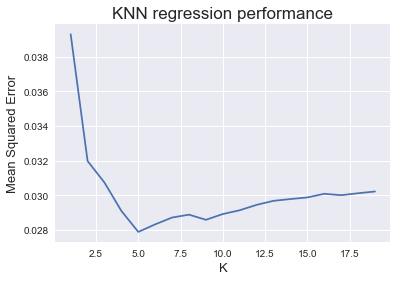

In [53]:
plot_knn_k_performance(X_train,y_train)

In [249]:
knn = KNeighborsRegressor(n_neighbors=5,weights='distance')
knn.fit(X_train,y_train)

# scoring our model on our validation set
print('KNN regression')
print('MSE: ' + str(np.mean((knn.predict(X_valid) - y_valid)**2)))
print('R2: ' + str(knn.score(X_valid, y_valid)))

KNN regression
MSE: 0.023459686324252035
R2: 0.798243277542


#### Ridge Regression with RBF kernel

In [250]:
from sklearn.kernel_ridge import KernelRidge

In [251]:
kernr = KernelRidge(alpha=0.3, )
kernr.fit(X_train, y_train)

# scoring our model on our validation set
print('Kernel Ridge regression')
print('MSE: ' + str(np.mean((kernr.predict(X_valid) - y_valid)**2)))
print('R2: ' + str(kernr.score(X_valid, y_valid)))


Kernel Ridge regression
MSE: 0.018283830048779665
R2: 0.842756396073


#### Try Random Forest to capture nonlinearity

In [291]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [292]:
# Grid searching for optimal parameter

rfr = RandomForestRegressor()

param_dist = dict(max_depth = [10,30,50,70,100], max_features = ['auto','sqrt'], min_samples_split = [20,60,100,200])

rgs = RandomizedSearchCV(rfr, param_dist, cv=10, scoring='neg_mean_squared_error',) 
rgs.fit(X_train, y_train,)

print(rgs.best_params_)
print(rgs.best_score_)

{'min_samples_split': 20, 'max_features': 'auto', 'max_depth': 70}
-0.0178803028196


In [293]:
rfr = RandomForestRegressor(n_estimators=120,random_state=5555,)
rffit = rfr.fit(X_train, y_train,)

In [294]:
print('Random Forest')
print('R2: ' + str(rfr.score(X_valid,y_valid)))
print('MSE: ' + str(sum((rfr.predict(X_valid) - np.array(y_valid))**2)/len(y_valid)))

Random Forest
R2: 0.873164570297
MSE: 0.0147480557742


#### Lets go one step further with Random Forest (ExtraTrees)

In [295]:
from sklearn.ensemble import ExtraTreesRegressor

In [296]:
xtr = ExtraTreesRegressor(n_estimators=120, bootstrap=True, random_state=5555)
xtr.fit(X_train, y_train)

print('Extra Trees')
print('R2: ' + str(xtr.score(X_valid,y_valid)))
print('MSE: ' + str(sum((xtr.predict(X_valid) - np.array(y_valid))**2)/len(y_valid)))

# The extra tree isn't doing beter than Random Forest

Extra Trees
R2: 0.862568634947
MSE: 0.0159801203944


#### Let's boost our Random Forest algorithm with Adaptive Boost

In [297]:
from sklearn.ensemble import AdaBoostRegressor


In [298]:
ada = AdaBoostRegressor(base_estimator=RandomForestRegressor(), n_estimators=100, loss= 'square', random_state=5555)
ada.fit(X_train,y_train)

print('Ada Boost')
print('R2: ' + str(ada.score(X_valid,y_valid)))
print('MSE: ' + str(sum((ada.predict(X_valid) - np.array(y_valid))**2)/len(y_valid)))

Ada Boost
R2: 0.881907449238
MSE: 0.0137314591769


#### Gradient boosting

In [300]:
from sklearn.ensemble import GradientBoostingRegressor

In [301]:
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1,random_state=5555)
gbr.fit(X_train,y_train)

print('XG Boost')
print('R2: ' + str(gbr.score(X_valid,y_valid)))
print('MSE: ' + str(sum((gbr.predict(X_valid) - np.array(y_valid))**2)/len(y_valid)))

XG Boost
R2: 0.884284832038
MSE: 0.0134550240025


In [302]:
# top 20 most important features from gbr

feat_importance = sorted(list(zip(X.columns, gbr.feature_importances_)),key=lambda x : x[1], reverse=True)
pprint(feat_importance[:20])

[('COUNT_NWNE_P10', 0.022557791266919168),
 ('DIVERSE', 0.018424538708586419),
 ('COUNT_WNE_MALE1_P10', 0.016431076596425728),
 ('COUNT_WNE_INDEP1_P10', 0.01334562378626237),
 ('FEMALE', 0.013289132819183713),
 ('PCIP50', 0.013156598999695967),
 ('DEP_STAT_PCT_IND', 0.012897030320139006),
 ('PELL_EVER', 0.012718600426512836),
 ('IND_INC_PCT_M1', 0.012488668198407441),
 ('AVGFACSAL', 0.011957403962487614),
 ('MD_FAMINC', 0.0097814092103512204),
 ('PCIP12', 0.0095311201017191753),
 ('IND_INC_AVG', 0.0095299551161176759),
 ('FIRSTGEN_ENRL_4YR_TRANS_YR3_RT', 0.0092368574551987791),
 ('COUNT_WNE_INC3_P10', 0.0092348944881085731),
 ('INEXPFTE', 0.0085769329267328769),
 ('COUNT_WNE_P10', 0.0084953791772117964),
 ('PCIP31', 0.00834640954457057),
 ('MARRIED', 0.008172294912140006),
 ('HI_INC_COMP_ORIG_YR3_RT', 0.0080687514749463486)]


## Analyzing the top features ranked according to feature importance

I want to do some interpretation with regards to the most important variables in my Gradient Boosting model. I am aware that because tree models are able to capture non-linear relationship, predictors that it deemed important may not be have a linear relationship with the target variable and vice versa, variables it deemed not important may have a linear relationship with the target variable. 

Because the Boosting model is a nonlinear model, I will show how nonlinearity could be a problem in our interpretation of the most important features if we use a linear model to interpret the boosting result by comparing the problematic  inteprretaion of the top features with that of a more widely used interpretation tool called the **partial dependence plot** (Friedman 2001).  
https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451

So my task in this section is two-fold:  

1. I will show how the the top varaibles would be interpreted in a linear regression model
2. I will show how 1's interpretation is problematic when compared to the partial dependece plot interpretation


### Linear model

In [303]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('error')

In [304]:
def multicollinearity_remover(predictor, target, threshold, wanna_keeps=[], dont_wanna_keeps=[]):
    '''
    remove predictor variables that have to a variance inflation factor above threshold
    
    predictor : predictor varaibles (matrix, dataframe etc.)
    target : target variable vector (series, list, etc.)
    threshold : a number above which a predictor variable will be deemed highly collinear with other predictor
                and be dropped from final predictor matrix (int,float)
    wanna_keeps : list of column names that you definitely want to keep in the predictor matrix returned, regardless
                  of VIF score
    dont_wanna_keeps : list of column names that you definitely do not want to keep in the predictor matrix returned,
                       regardless of VIF score
    return : a predictor dataframe with highly collinear varaibles dropped
    '''
    vifs = [threshold]
    predictor_c = predictor.copy()
    if dont_wanna_keeps != []:
        for feat in dont_wanna_keeps:
            try:
                predictor_c.drop([feat], axis = 1, inplace = True)
            except ValueError:
                continue
    
    model = sm.GLM(target, predictor_c)
    result = model.fit()
    keeps = []
    while list(filter(lambda x : x >= threshold, vifs)):
    
        predictor_name = pd.Series(result.params).index
        current_vifs = []
        for i in range(1,len(predictor_name)):
            try:
                vif = variance_inflation_factor(result.model.exog, i)
                current_vifs.append(vif)
            except Warning:
                predictor_c = predictor_c.drop(predictor_name[i], axis = 1)

        vifs = current_vifs

        # index of variable with highest vif
        max_index = current_vifs.index(max(current_vifs))

        col_name = predictor_name[max_index + 1]
        
        # check if variable in wanna_keep
        if wanna_keeps != [] and col_name in wanna_keeps:
            col = predictor_c[col_name]
            name = col_name
            keeps.append((name,col))
            
        # remove that variable
        predictor_c = predictor_c.drop(col_name, axis = 1)
        
        # refit model
        model = sm.OLS(target, predictor_c)
        result = model.fit()
    
    # adding wanna_keeps
    for i in range(len(keeps)):
        if keeps[i][0] not in predictor_c.columns:
            predictor_c.insert(i+1,keeps[i][0],keeps[i][1])
            
    return  predictor_c


###### didnt end up using this
def p_value_feature_selection(predictor, target, threshold, wanna_keeps=[], dont_wanna_keeps=[]):
    
    predictor_c = predictor.copy()
    if dont_wanna_keeps != []:
        for feat in dont_wanna_keeps:
            try:
                predictor_c.drop([feat], axis = 1, inplace = True)
            except ValueError:
                continue
    model = sm.GLM(target, predictor_c)
    result = model.fit()
    p_vals = list(result.pvalues)
    keeps = []
    while list(filter(lambda x : x >= threshold, p_vals)):
        
        p_vals = list(result.pvalues)
        largest_p_val = max(p_vals)
        index = p_vals.index(largest_p_val)
        col_name = predictor_c.columns[index]
        
        if wanna_keeps != [] and col_name in wanna_keeps:
            col = predictor_c[col_name]
            name = col_name
            keeps.append((name,col))
        
        predictor_c.drop(col_name,axis = 1, inplace= True)
        
        model = sm.GLM(target, predictor_c)
        result = model.fit()
        p_vals = list(result.pvalues)
        
    # adding wanna_keeps
    for i in range(len(keeps)):
        if keeps[i][0] not in predictor_c.columns:
            predictor_c.insert(i+1,keeps[i][0],keeps[i][1])
    
    return predictor_c

In [305]:
# retrieving top19 features boosting model names. Add intercept

top20 = list(map(lambda x : x[0], feat_importance[:19]))
top20.insert(0,'INTERCEPT')

#### If we are going to fit a linear model we should remove highly colllinear varaibles first as determined by the varaince inflation factor

In [376]:
top20_cleaned = multicollinearity_remover(
    standardize(X_train[top20],['PREDDEG','HIGHDEG','CONTOL','REGION','ICLEVEL','ISNULL','EARN','INTERCEPT']),
    y_train,
    5, # VIF < 5 as cutoff
    )

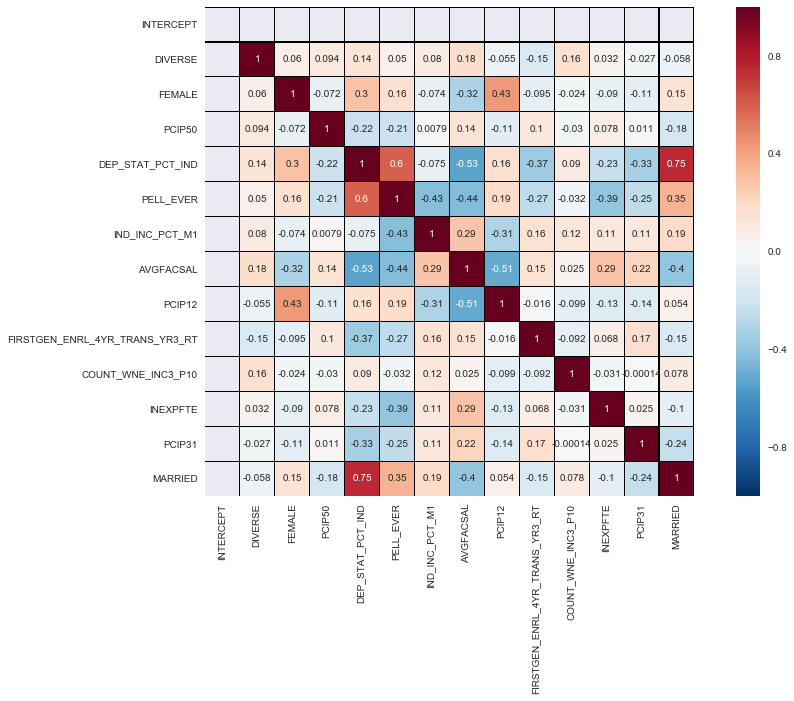

In [390]:
f, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(top20_cleaned.corr(method = 'pearson'),
            linewidths=0.25,
            vmax=1.0,
            square=True,
            linecolor='black',
            annot=True, 
            xticklabels = list(top20_cleaned.columns),
            yticklabels = list(top20_cleaned.columns),)



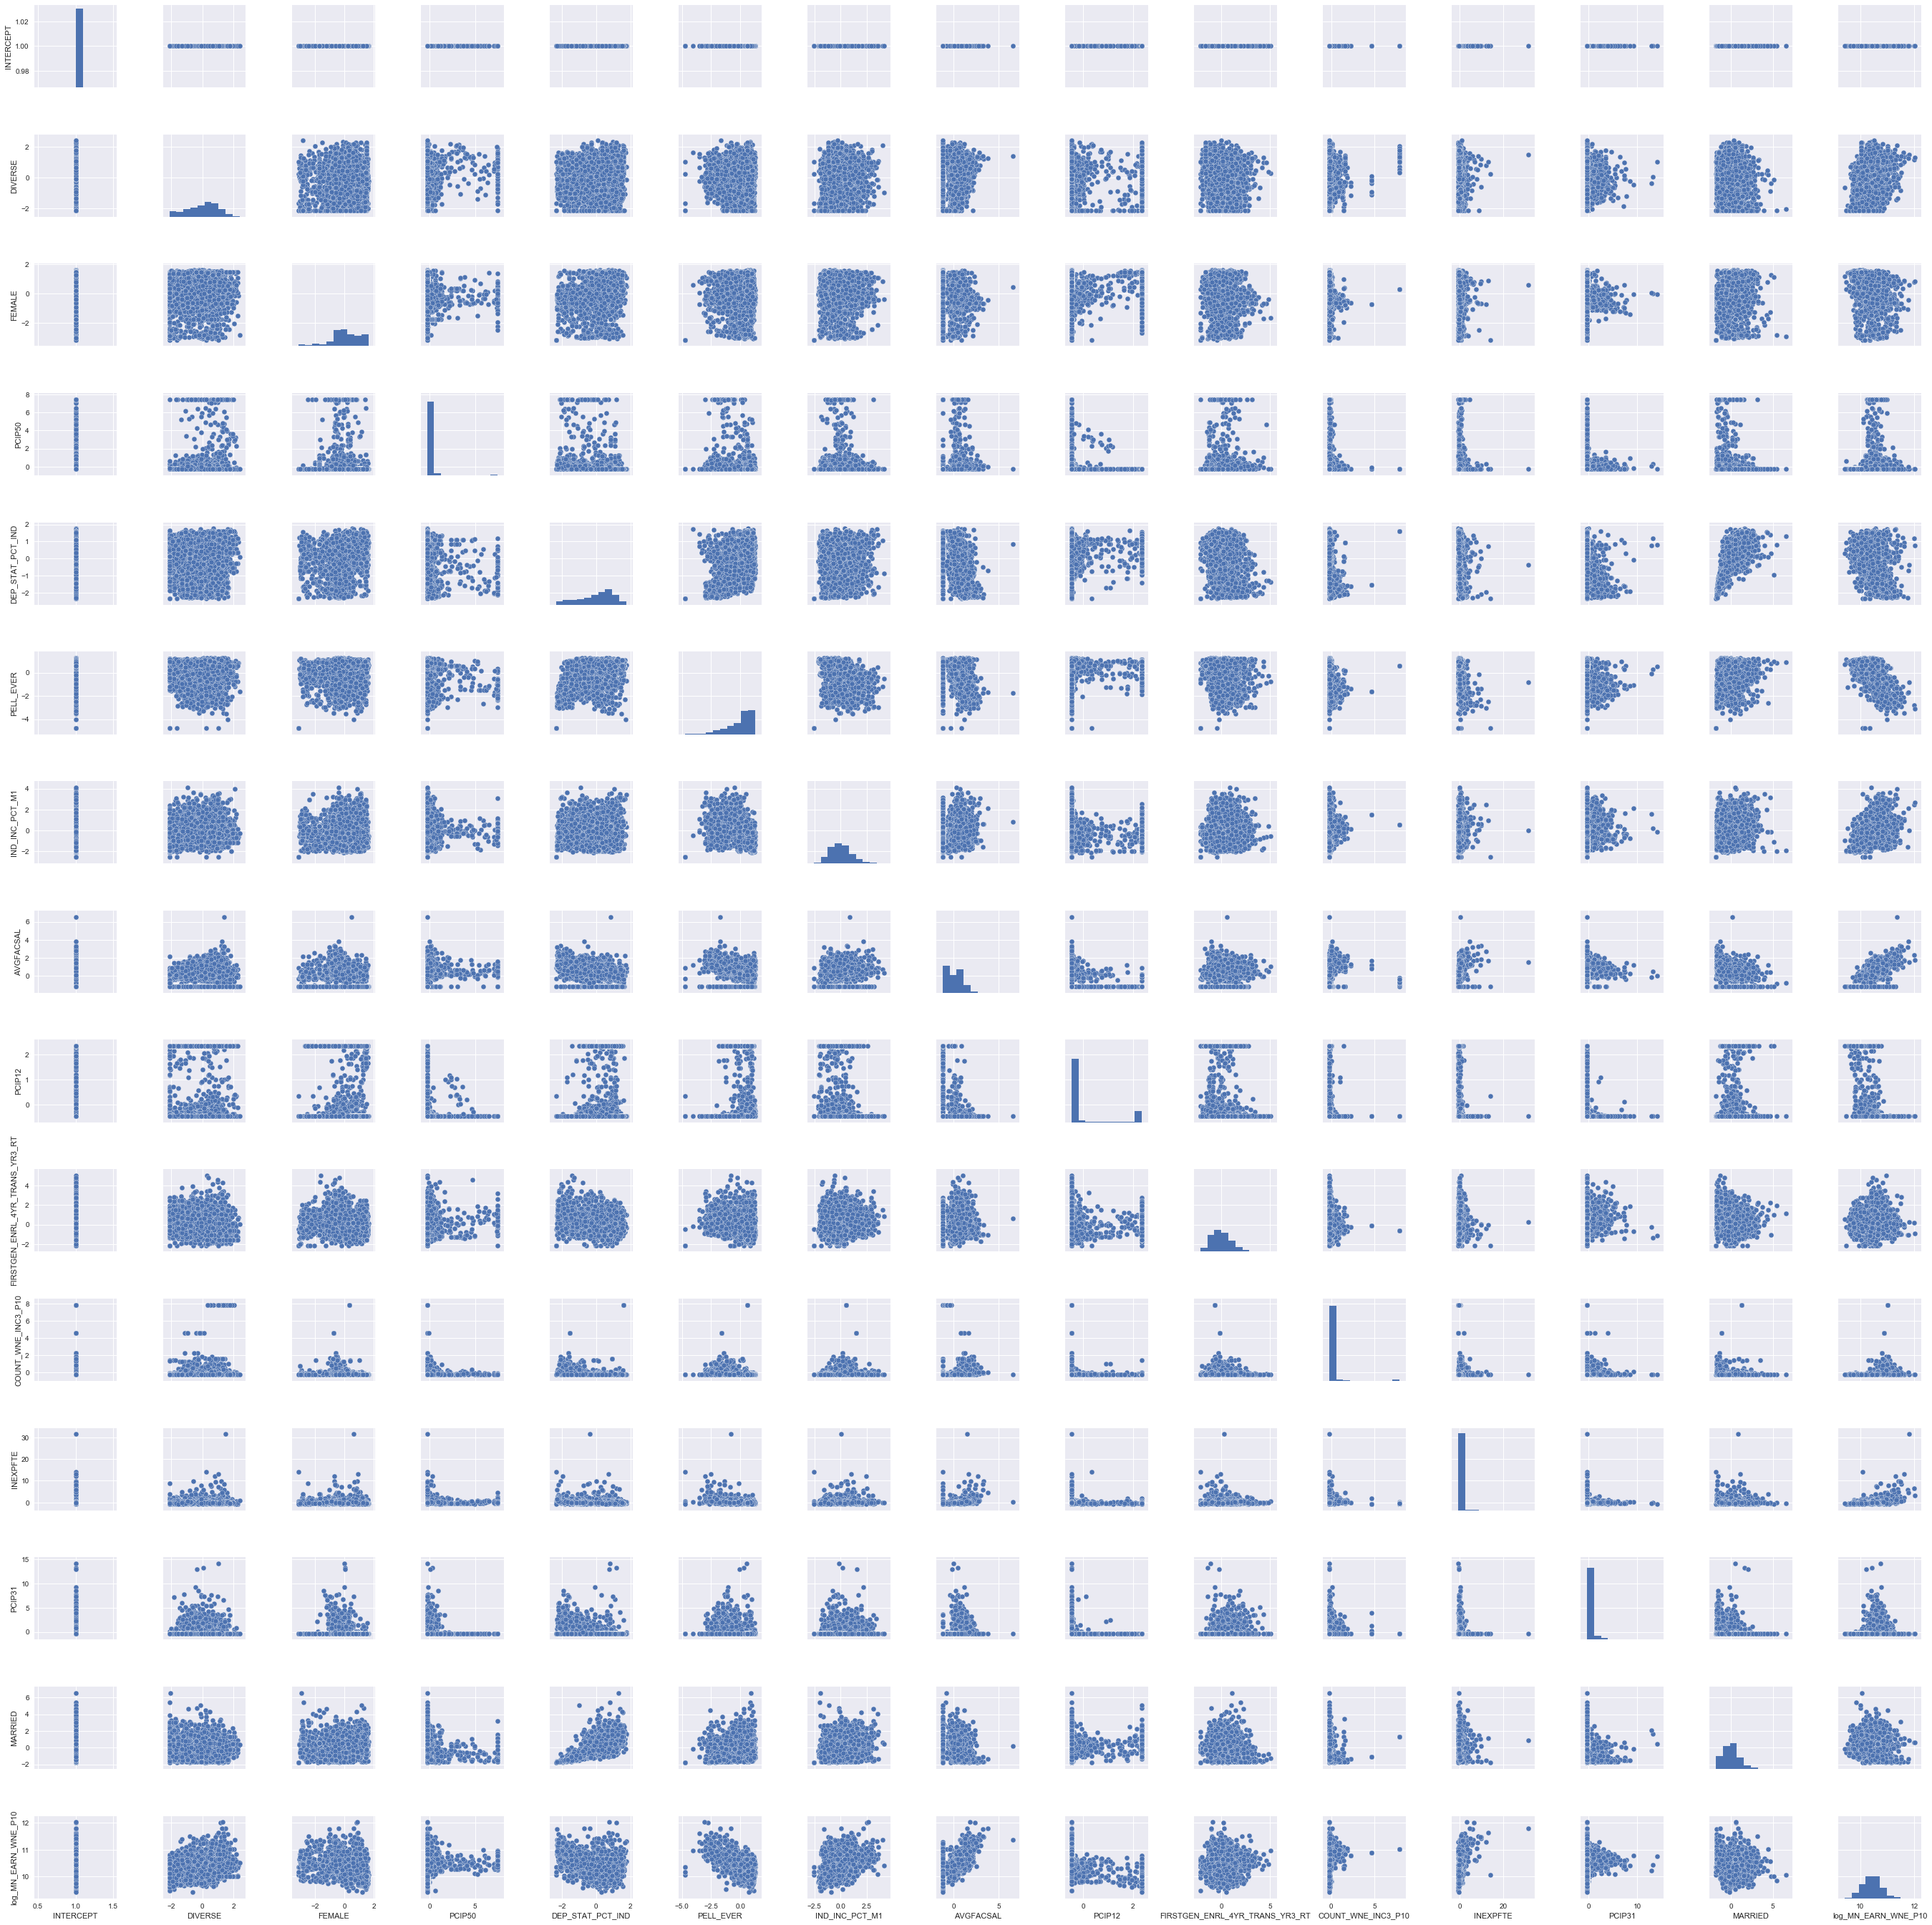

In [391]:
sns.pairplot(pd.concat([top20_cleaned,y_train],axis = 1))

In [326]:
lr = sm.OLS(y_train, top20_cleaned)
result = lr.fit(cov_type='HC0') # White's robust standard error
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_MN_EARN_WNE_P10   R-squared:                       0.794
Model:                             OLS   Adj. R-squared:                  0.794
Method:                  Least Squares   F-statistic:                     1278.
Date:                 Sat, 09 Sep 2017   Prob (F-statistic):               0.00
Time:                         16:04:29   Log-Likelihood:                 1557.8
No. Observations:                 3521   AIC:                            -3088.
Df Residuals:                     3507   BIC:                            -3001.
Df Model:                           13                                         
Covariance Type:                   HC0                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
INTERCEPT                         10.4286      0.003   3980.599      0.000      10.423      10.434
DIVERSE                            0.0558      0.003     17.372      0.000       0.049       0.062
FEMALE                            -0.0475      0.004    -12.752      0.000      -0.055      -0.040
PCIP50                            -0.0217      0.003     -8.310      0.000      -0.027      -0.017
DEP_STAT_PCT_IND                   0.0434      0.007      6.166      0.000       0.030       0.057
PELL_EVER                         -0.1377      0.006    -21.296      0.000      -0.150      -0.125
IND_INC_PCT_M1                     0.0630      0.005     12.686      0.000       0.053       0.073
AVGFACSAL                          0.0790      0.006     13.954      0.000       0.068       0.090
PCIP12                            -0.0847      0.004    -23.347      0.000      -0.092      -0.078
FIRSTGEN_ENRL_4YR_TRANS_YR3_RT     0.0099      0.003      2.989      0.003       0.003       0.016
COUNT_WNE_INC3_P10                 0.0695      0.002     45.024      0.000       0.067       0.073
INEXPFTE                           0.0397      0.007      5.620      0.000       0.026       0.053
PCIP31                            -0.0055      0.003     -1.807      0.071      -0.011       0.000
MARRIED                           -0.0143      0.005     -2.601      0.009      -0.025      -0.004
==============================================================================
Omnibus:                      261.720   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1361.042
Skew:                           0.097   Prob(JB):                    2.84e-296
Kurtosis:                       6.040   Cond. No.                         4.89
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

#### Visually inspecting our residual plot for signs of heteroskedasticity

In [320]:
from scipy import stats

((array([-3.5442826 , -3.30328406, -3.17015872, ...,  3.17015872,
          3.30328406,  3.5442826 ]),
  array([-1.3464235 , -0.76945627, -0.70701762, ...,  0.6504677 ,
          0.66878977,  0.67084487])),
 (0.15352332139627636, -1.477186261222361e-15, 0.9866561573103082))

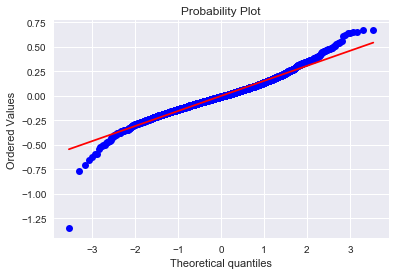

In [333]:
## qq plot to check out distribution of the errors
## not normal as it is a bit far off from the theoretical quanitle at the tails

stats.probplot(result.resid, dist="norm", plot=plt)

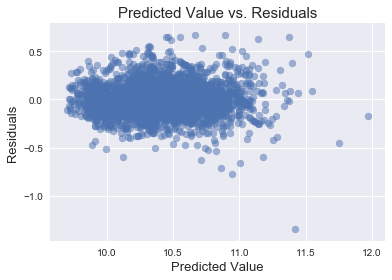

In [332]:

plt.scatter(result.predict(top20_cleaned), result.resid, alpha = 0.5)
plt.title('Predicted Value vs. Residuals', size = 15)
plt.xlabel('Predicted Value', size = 13)
plt.ylabel('Residuals', size = 13)

#### Testing for heteroskedasticity (Statistically)

In [318]:
def bp_test(fit_result):
    '''
    (test for linear heteroskedasticity)
    given the fit result, run a auxillary regression of the squared residuals 
    on the exogenous (RHS) variables to test whether the predictors are jointly significant
    
    fit_result : a Linear Regression fit object
    return : the p_value of the F-statistics of the zuxillary regression
    '''
    resid_sq = fit_result.resid**2
    
    test_model = sm.OLS(list(resid_sq), fit_result.model.exog)
    results = test_model.fit()
    
    return results.f_pvalue

def white_test(fit_result):
    '''
    (test for nonlinear heteroskedasticity)
    given the fit result, run a auxillary regression of the squared residuals 
    on the predicted values and its square to test whether the predictors are jointly significant
    
    fit_result : a Linear Regression fit object
    return : the p_value of the F-statistics of the auxillary regression
    '''
    resid_sq = fit_result.resid**2
    predicted = pd.Series(fit_result.predict(fit_result.model.exog))
    
    X = pd.concat([predicted,predicted**2],axis = 1,)
    X.insert(0,'INTERCEPT',[1]*len(X))
    
    test_model = sm.OLS(list(resid_sq), X)
    results = test_model.fit()
    
    return results.f_pvalue


In [319]:
print('BP Test: ' + str(bp_test(result)))
print("White's Test: " + str(white_test(result)))

BP Test: 1.7988716841e-74
White's Test: 1.92785960472e-17


Given both the test's p_value indicates the presence of heteroskedasticity, I am going to go back to my OLS above and estimate the standard error with White's robust standard error

For more details regarding heteroskeasticity please refer:  
http://www3.grips.ac.jp/~yamanota/Lecture_Note_9_Heteroskedasticity

For more details regarding heteroskedasticity consistent (HAC) standard error please refer here:  
http://chrisauld.com/2012/10/31/the-intuition-of-robust-standard-errors/

#### What the regression result means

What is returned to us by the linear regression model result is the average effect a variable has on the response varaible holding everyitng else constant. It also provides the statisical significance at the 95% confidence interval. For most of these varaibles the results are statistically significant. I have not even included the missing binary indicators for each variable and interaction terms making this likely still an oversimplified model. But for the point I am trying to make this will be sufficient.


**Problem of average effect :**  
The meaning of the 'the average effect' is kind of like fitting a straight line (plane, hyperplane,...) with a fixed slope saying that for one standard deviation increase (standardized $x_i$ variables) in one of our variable $x_i$ for example we see on average approximately a ($\beta_{x_i}$ * 100)% increase in our target variable across all levels, holding other inputs constant. But this constant increase clearly may not be case and most likely is not. In other words the (strength) relationship between any of our inputs and output could vary across different level of our input variable domain

### Partial Dependence plot

In [343]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [369]:
gbr_feat = sorted(list(zip(X_train, zip(gbr.feature_importances_, range(len(gbr.feature_importances_))))),key=lambda x : x[1], reverse=True)
gbr_feat[:20]

[('COUNT_NWNE_P10', (0.022557791266919168, 930)),
 ('DIVERSE', (0.018424538708586419, 990)),
 ('COUNT_WNE_MALE1_P10', (0.016431076596425728, 949)),
 ('COUNT_WNE_INDEP1_P10', (0.01334562378626237, 945)),
 ('FEMALE', (0.013289132819183713, 918)),
 ('PCIP50', (0.013156598999695967, 94)),
 ('DEP_STAT_PCT_IND', (0.012897030320139006, 796)),
 ('PELL_EVER', (0.012718600426512836, 914)),
 ('IND_INC_PCT_M1', (0.012488668198407441, 816)),
 ('AVGFACSAL', (0.011957403962487614, 336)),
 ('MD_FAMINC', (0.0097814092103512204, 928)),
 ('PCIP12', (0.0095311201017191753, 40)),
 ('IND_INC_AVG', (0.0095299551161176759, 834)),
 ('FIRSTGEN_ENRL_4YR_TRANS_YR3_RT', (0.0092368574551987791, 552)),
 ('COUNT_WNE_INC3_P10', (0.0092348944881085731, 939)),
 ('INEXPFTE', (0.0085769329267328769, 334)),
 ('COUNT_WNE_P10', (0.0084953791772117964, 932)),
 ('PCIP31', (0.00834640954457057, 68)),
 ('MARRIED', (0.008172294912140006, 920)),
 ('HI_INC_COMP_ORIG_YR3_RT', (0.0080687514749463486, 502))]

In [370]:
sample_var_index = [930,990,918,796,914,336,928,40,334,932]

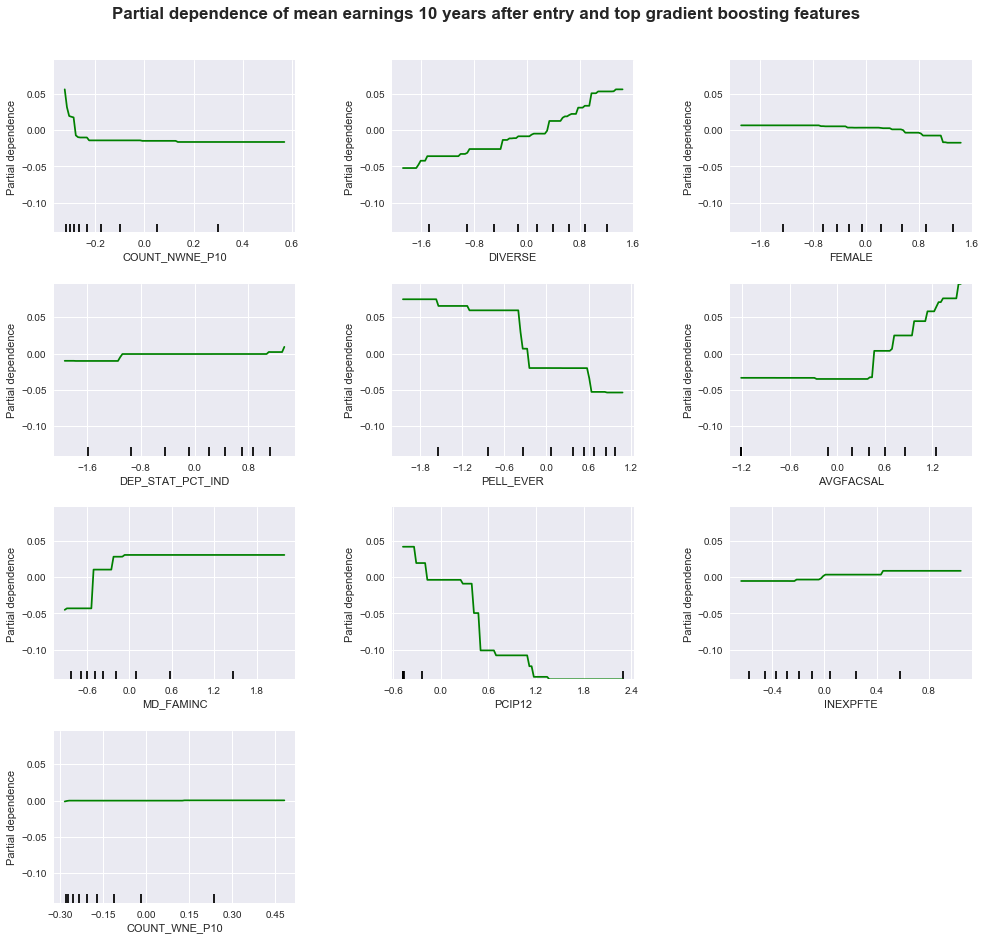

In [372]:
# one way partial dependence plot
fig, ax = plt.subplots(figsize=(15,15))
plot_partial_dependence(gbr, X_train, features=sample_var_index, 
                        feature_names=X_train.columns,
                        ax=ax)

fig.suptitle('Partial dependence of mean earnings 10 years after entry and top gradient boosting features',
            fontsize=17, fontweight='bold')
plt.subplots_adjust(top=0.93)  # tight_layout causes overlap with suptitle

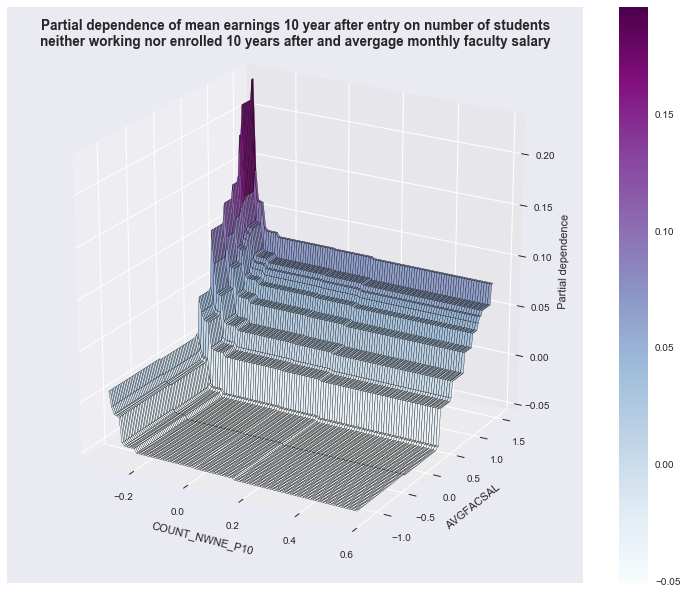

In [374]:
# two way partial dependence plot
fig = plt.figure(figsize=(10,8))
target_feature = (930,336)
pdp, axes = partial_dependence(gbr, target_feature,
                               X=X_train, grid_resolution=100)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(X_train.columns[target_feature[0]], labelpad=10)
ax.set_ylabel(X_train.columns[target_feature[1]], labelpad=10)
ax.set_zlabel('Partial dependence',labelpad=10)
#  pretty init view
ax.view_init(elev=22, azim=300)
plt.colorbar(surf)
plt.suptitle('''Partial dependence of mean earnings 10 year after entry on number of students
neither working nor enrolled 10 years after and avergage monthly faculty salary''',
            fontsize=13.5, fontweight='bold',x = 0.4)

fig.subplots_adjust(top=0.5)

plt.show()

### Test our models on the hold out test set

In [366]:
print('Ridge')
print('R2: ' + str(rcv.score(X_test,y_test)))
print('MSE: ' + str(np.mean((rcv.predict(X_test)-y_test)**2)))
print('\n\n')

print('Lasso')
print('R2: ' + str(lcv.score(X_test,y_test)))
print('MSE: ' + str(np.mean((lcv.predict(X_test)-y_test)**2)))
print('\n\n')

print('Elastic Net')
print('R2: ' + str(encv.score(X_test,y_test)))
print('MSE: ' + str(np.mean((encv.predict(X_test)-y_test)**2)))
print('\n\n')

print('KNN Regression')
print('R2: ' + str(knn.score(X_test,y_test)))
print('MSE: ' + str(np.mean((knn.predict(X_test)-y_test)**2)))
print('\n\n')

print('Kernel Ridge Regression')
print('R2: ' + str(kernr.score(X_test,y_test)))
print('MSE: ' + str(np.mean((kernr.predict(X_test)-y_test)**2)))
print('\n\n')

print('Random Forest')
print('R2: ' + str(rfr.score(X_test,y_test)))
print('MSE: ' + str(np.mean((rfr.predict(X_test)-y_test)**2)))
print('\n\n')

print('Extra Trees')
print('R2: ' + str(xtr.score(X_test,y_test)))
print('MSE: ' + str(np.mean((xtr.predict(X_test) - np.array(y_test))**2)))
print('\n\n')

print('Adaptive Boosting')
print('R2: ' + str(ada.score(X_test,y_test)))
print('MSE: ' + str(np.mean((ada.predict(X_test)-y_test)**2)))
print('\n\n')

print('Gradient Tree Boosting')
print('R2: ' + str(gbr.score(X_test,y_test)))
print('MSE: ' + str(np.mean((gbr.predict(X_test)-y_test)**2)))
print('\n\n')

Ridge
R2: 0.832314370898
MSE: 0.02077211521545788



Lasso
R2: 0.834500354114
MSE: 0.020501325789651147



Elastic Net
R2: 0.839511725535
MSE: 0.01988054042414798



KNN Regression
R2: 0.802689629798
MSE: 0.024441890250122573



Kernel Ridge Regression
R2: 0.654803116155
MSE: 0.04276138320043233



Random Forest
R2: 0.864988506726
MSE: 0.016724595355735943



Extra Trees
R2: 0.860932936018
MSE: 0.0172269805777



Adaptive Boosting
R2: 0.869938356223
MSE: 0.01611143103980017



Gradient Tree Boosting
R2: 0.870711284792
MSE: 0.016015684246327287





### Exporting out a dataframe with top variables for visualization

I will pick the top 45 features from the tree model and put them in a new dataframe. 

In [168]:
def retrieve_features_for_vis(num, features):
    '''
    This is a function that specfically handles and retrieves the
    top 45 features from my tree model specific to my dataset for 
    scatterplot visualization later. It excludes categorical variables or 
    variables with too many null values. 

    
    num : number of features to retrieve
    return : list of top feature I want
    '''
    important_col = []
    for feat in features[4:num]:
        
        if 'COUNT' in feat[0]:
            continue
        important_col.append(feat[0])

    important_col = sorted(important_col)
    
    # manually inserting school name and target varaible in the final list of names returned
    important_col.insert(0,'UNITID')
    important_col.insert(0,'MN_EARN_WNE_P10')
    
    # Either binary columns that I dont really want for my visualization
    # Or to many 0s in the feature (poor for visualization)
    important_col.pop(important_col.index('PREDDEG[T.certificate]'))
    important_col.pop(important_col.index('D100_L4'))
    important_col.pop(important_col.index('RET_FTL4'))
    important_col.pop(important_col.index('PCIP50'))
    important_col.pop(important_col.index('ICLEVEL[T.4_year]'))
    important_col.pop(important_col.index('PCIP12'))
    important_col.pop(important_col.index('ICLEVEL[T.4_year]'))
    important_col.pop(important_col.index('PREDDEG[T.bachelor]'))
    
    
    return important_col

def remove_any_ones(df, important_feat,):
    '''
    This is a function that specfically handles remove
    observations from dataframe that has a value of 1 in a _ISNULL column 
    indicating that data was missing
    
    return : a dataframe with data that meets the condition above removed
    '''
    important_feat_c = important_feat[:]
    
    # creating a list of null value indicator for varaibles
    nulls = []
    for feat in important_feat:
        if 'UGDS' not in feat and 'UNITID' not in feat:
            nulls.append(feat + '_ISNULL')
            
    # adding null indicators to the list      
    important_feat_c.extend(nulls) 
    
    df_c  = df[important_feat_c].copy()
    for i,row in df.iterrows():
        if sum(row[nulls]) > 0:
            df_c.drop(i, inplace = True)
        
    return df_c
    

In [169]:
important_feat = retrieve_features_for_vis(40)

In [170]:
df_vis = remove_any_ones(df_college, important_feat)

In [171]:
df_vis.shape

(4065, 58)

#### Now we dont really want to keep the _ISNULL column so lets drop them

In [172]:
dont_want = df_vis.columns[df_vis.columns.str.contains('_ISNULL')]
df_vis.drop(dont_want, axis =1, inplace=True)

In [173]:
df_joined = id_name.set_index('UNITID').join(df_vis.set_index('UNITID'),how = 'right')


In [174]:
df_joined.to_csv('df_joined.csv',index=False, )